In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import arviz
import ipywidgets
from matplotlib import cm, pyplot
import numpy
import os
import pandas
import pathlib
import pymc3

import calibr8
import cutisplit
import pyrff
import retl
import robotools

import run_analysis


print(f"pymc {pymc3.__version__}")
print(f"calibr8 {calibr8.__version__}")

pymc 4.0
calibr8 6.0.3


In [4]:
RUN_ID = "BZACW9"
resultpath = f'{RUN_ID}_Results' 
cm_nitrophenol = cutisplit.NitrophenolAbsorbanceModel.load(rf"{resultpath}\{RUN_ID}_cm_nitrophenol.json")
df_inputs, df_kinetics = run_analysis.read_rounds(["BZACW9", "BWA7DQ"])
df_inputs

C:\Users\helleckes\AppData\Local\Continuum\miniconda3\envs\dibecs_5.0.0\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


supernatant_well strain fp_well
culture_id                                
BZACW9_A07              B01   NprE     A07
BZACW9_B07              B02   YpjP     B07
BZACW9_C07              B03    Mpr     C07
BZACW9_D07              B04   YwaD     D07
BZACW9_E07              B05   SacC     E07
BZACW9_F07              B06    Pel     F07
BZACW9_A05              D01   CwlS     A05
BZACW9_B05              D02   YolA     B05
BZACW9_C05              D03    Bsn     C05
BZACW9_D05              D04   LipA     D05
BZACW9_E05              D05   AbnA     E05
BZACW9_F05              D06   SacB     F05
BZACW9_A04              E01   PhoB     A04
BZACW9_B04              E02    Bpr     B04
BZACW9_C04              E03    Vpr     C04
BZACW9_D04              E04   LipB     D04
BZACW9_E04              E05   AmyE     E04
BZACW9_F04              E06   NprB     F04
BZACW9_A02              G01   YwmC     A02
BZACW9_B02              G02   PelB     B02
BZACW9_C02              G03   YncM     C02
BZACW9_D02              G04   YoaW     D02
BZACW9_E02              G05   AprE     E02
BZACW9_F02              G06    Epr     F02
BWA7DQ_A07              B01    Bsn     A07
BWA7DQ_B07              B02   CwlS     B07
BWA7DQ_C07              B03    Vpr     C07
BWA7DQ_D07              B04   YwaD     D07
BWA7DQ_E07              B05   YolA     E07
BWA7DQ_F07              B06   AbnA     F07
BWA7DQ_A05              D01   PhoB     A05
BWA7DQ_B05              D02   LipB     B05
BWA7DQ_C05              D03    Bpr     C05
BWA7DQ_D05              D04   AprE     D05
BWA7DQ_E05              D05   SacC     E05
BWA7DQ_F05              D06   SacB     F05
BWA7DQ_A04              E01   LipA     A04
BWA7DQ_B04              E02    Mpr     B04
BWA7DQ_C04              E03   PelB     C04
BWA7DQ_D04              E04   YpjP     D04
BWA7DQ_E04              E05   AmyE     E04
BWA7DQ_F04              E06   NprE     F04
BWA7DQ_A02              G01   YncM     A02
BWA7DQ_B02              G02    Pel     B02
BWA7DQ_C02              G03   YwmC     C02
BWA7DQ_D02              G04   YoaW     D02
BWA7DQ_E02              G05   NprB     E02
BWA7DQ_F02              G06    Epr     F02

## Creating the Model

In [5]:
model = cutisplit.LongFormModel(
    df_inputs,
    df_kinetics=df_kinetics,
    cm_nitrophenol=cm_nitrophenol,
)
# the shapes of the dataset are encoded in the "coords" of the underlying PyMC3 model:
model.summary()

strain              (24,)	AbnA, AmyE, AprE, …, YwmC
culture_id          (48,)	BWA7DQ_A02, BWA7DQ_A04, BWA7DQ_A05, …, BZACW9_F07
kinetic_id          (192,)	BWA7DQ_1_B01, BWA7DQ_1_B02, BWA7DQ_1_B03, …, BZACW9_2_G12
cutinase_cycle      (30,)	0, 1, 2, …, 29


The PyMC3 model can be visualized as a graph:

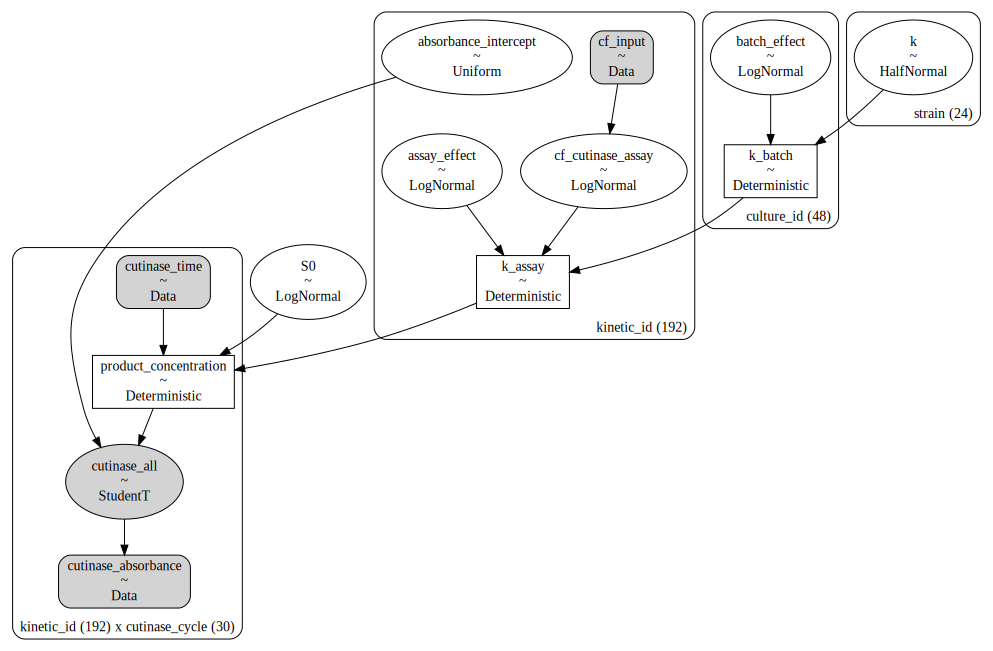

In [6]:
pymc3.model_to_graphviz(model.pmodel)

In [7]:
with model.pmodel:
    idata = pymc3.sample(return_inferencedata=True, target_accept=0.9)
idata

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cf_cutinase_assay, k, batch_effect, assay_effect, S0, absorbance_intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 656 seconds.


0, dim: kinetic_id, 192 =? 192
1, dim: cutinase_cycle, 30 =? 30


The number of effective samples is smaller than 25% for some parameters.


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

The result should be saved such that the analysis can run in another notebook.

In [8]:
idata.to_netcdf(fr"{resultpath}\{RUN_ID}_result_hierarchical_non_centered.nc")

'BZACW9_Results\\BZACW9_result_hierarchical_non_centered.nc'

Execute the next cell in case you want to reload saved data

In [ ]:
#idata = arviz.from_netcdf(fr"{resultpath}\{RUN_ID}_result_hierarchical_non_centered.nc")

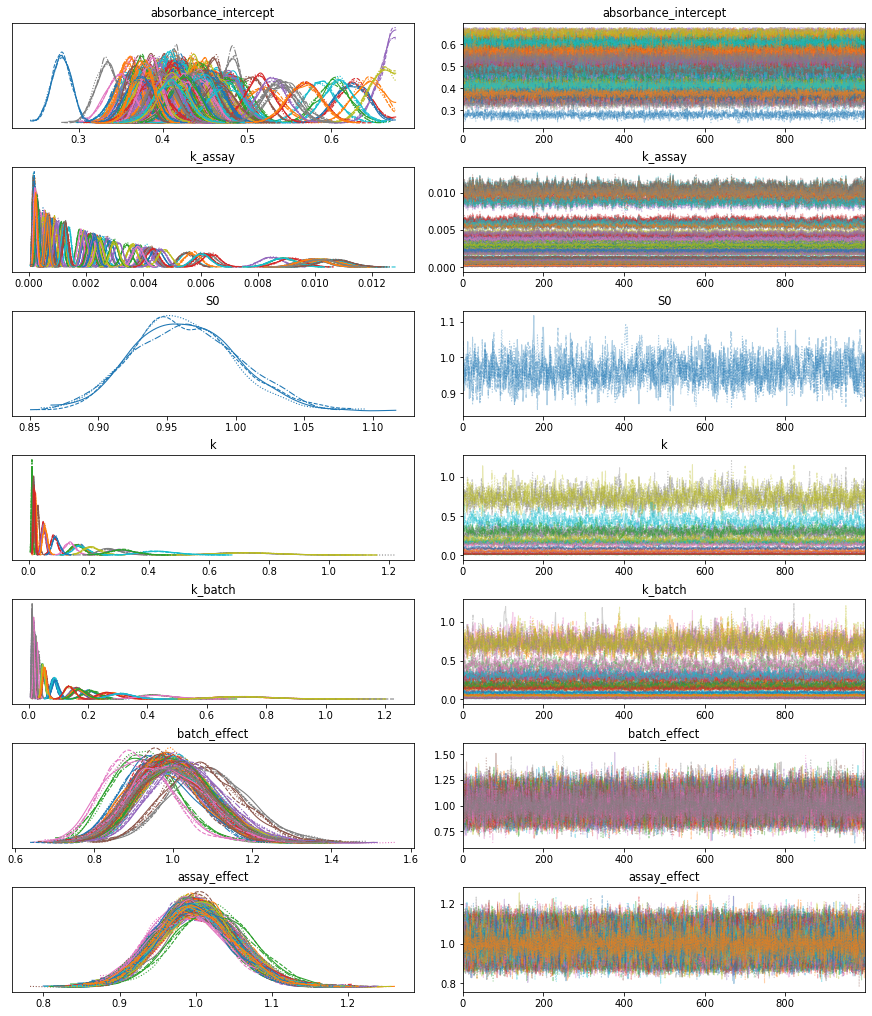

In [9]:
# For every "type" there is a vmax and fmax result:
arviz.plot_trace(idata, var_names=[ 
    "absorbance_intercept", "k_assay", 
    "S0", "k", "k_batch", "batch_effect", "assay_effect"
]);
# The left subplots show the posterior probability density.
# The right subplots show the MCMC. If they look like random noise everything is fine.
# The linestyle corresponds to independent MCMC chains - they should come to the same result.

C:\Users\helleckes\AppData\Local\Continuum\miniconda3\envs\dibecs_5.0.0\lib\site-packages\arviz\plots\backends\matplotlib\pairplot.py:238: UserWarning: rcParams['plot.max_subplots'] (144) is smaller than the number of resulting pair plots with these variables, generating only a 16x16 grid
  warnings.warn(


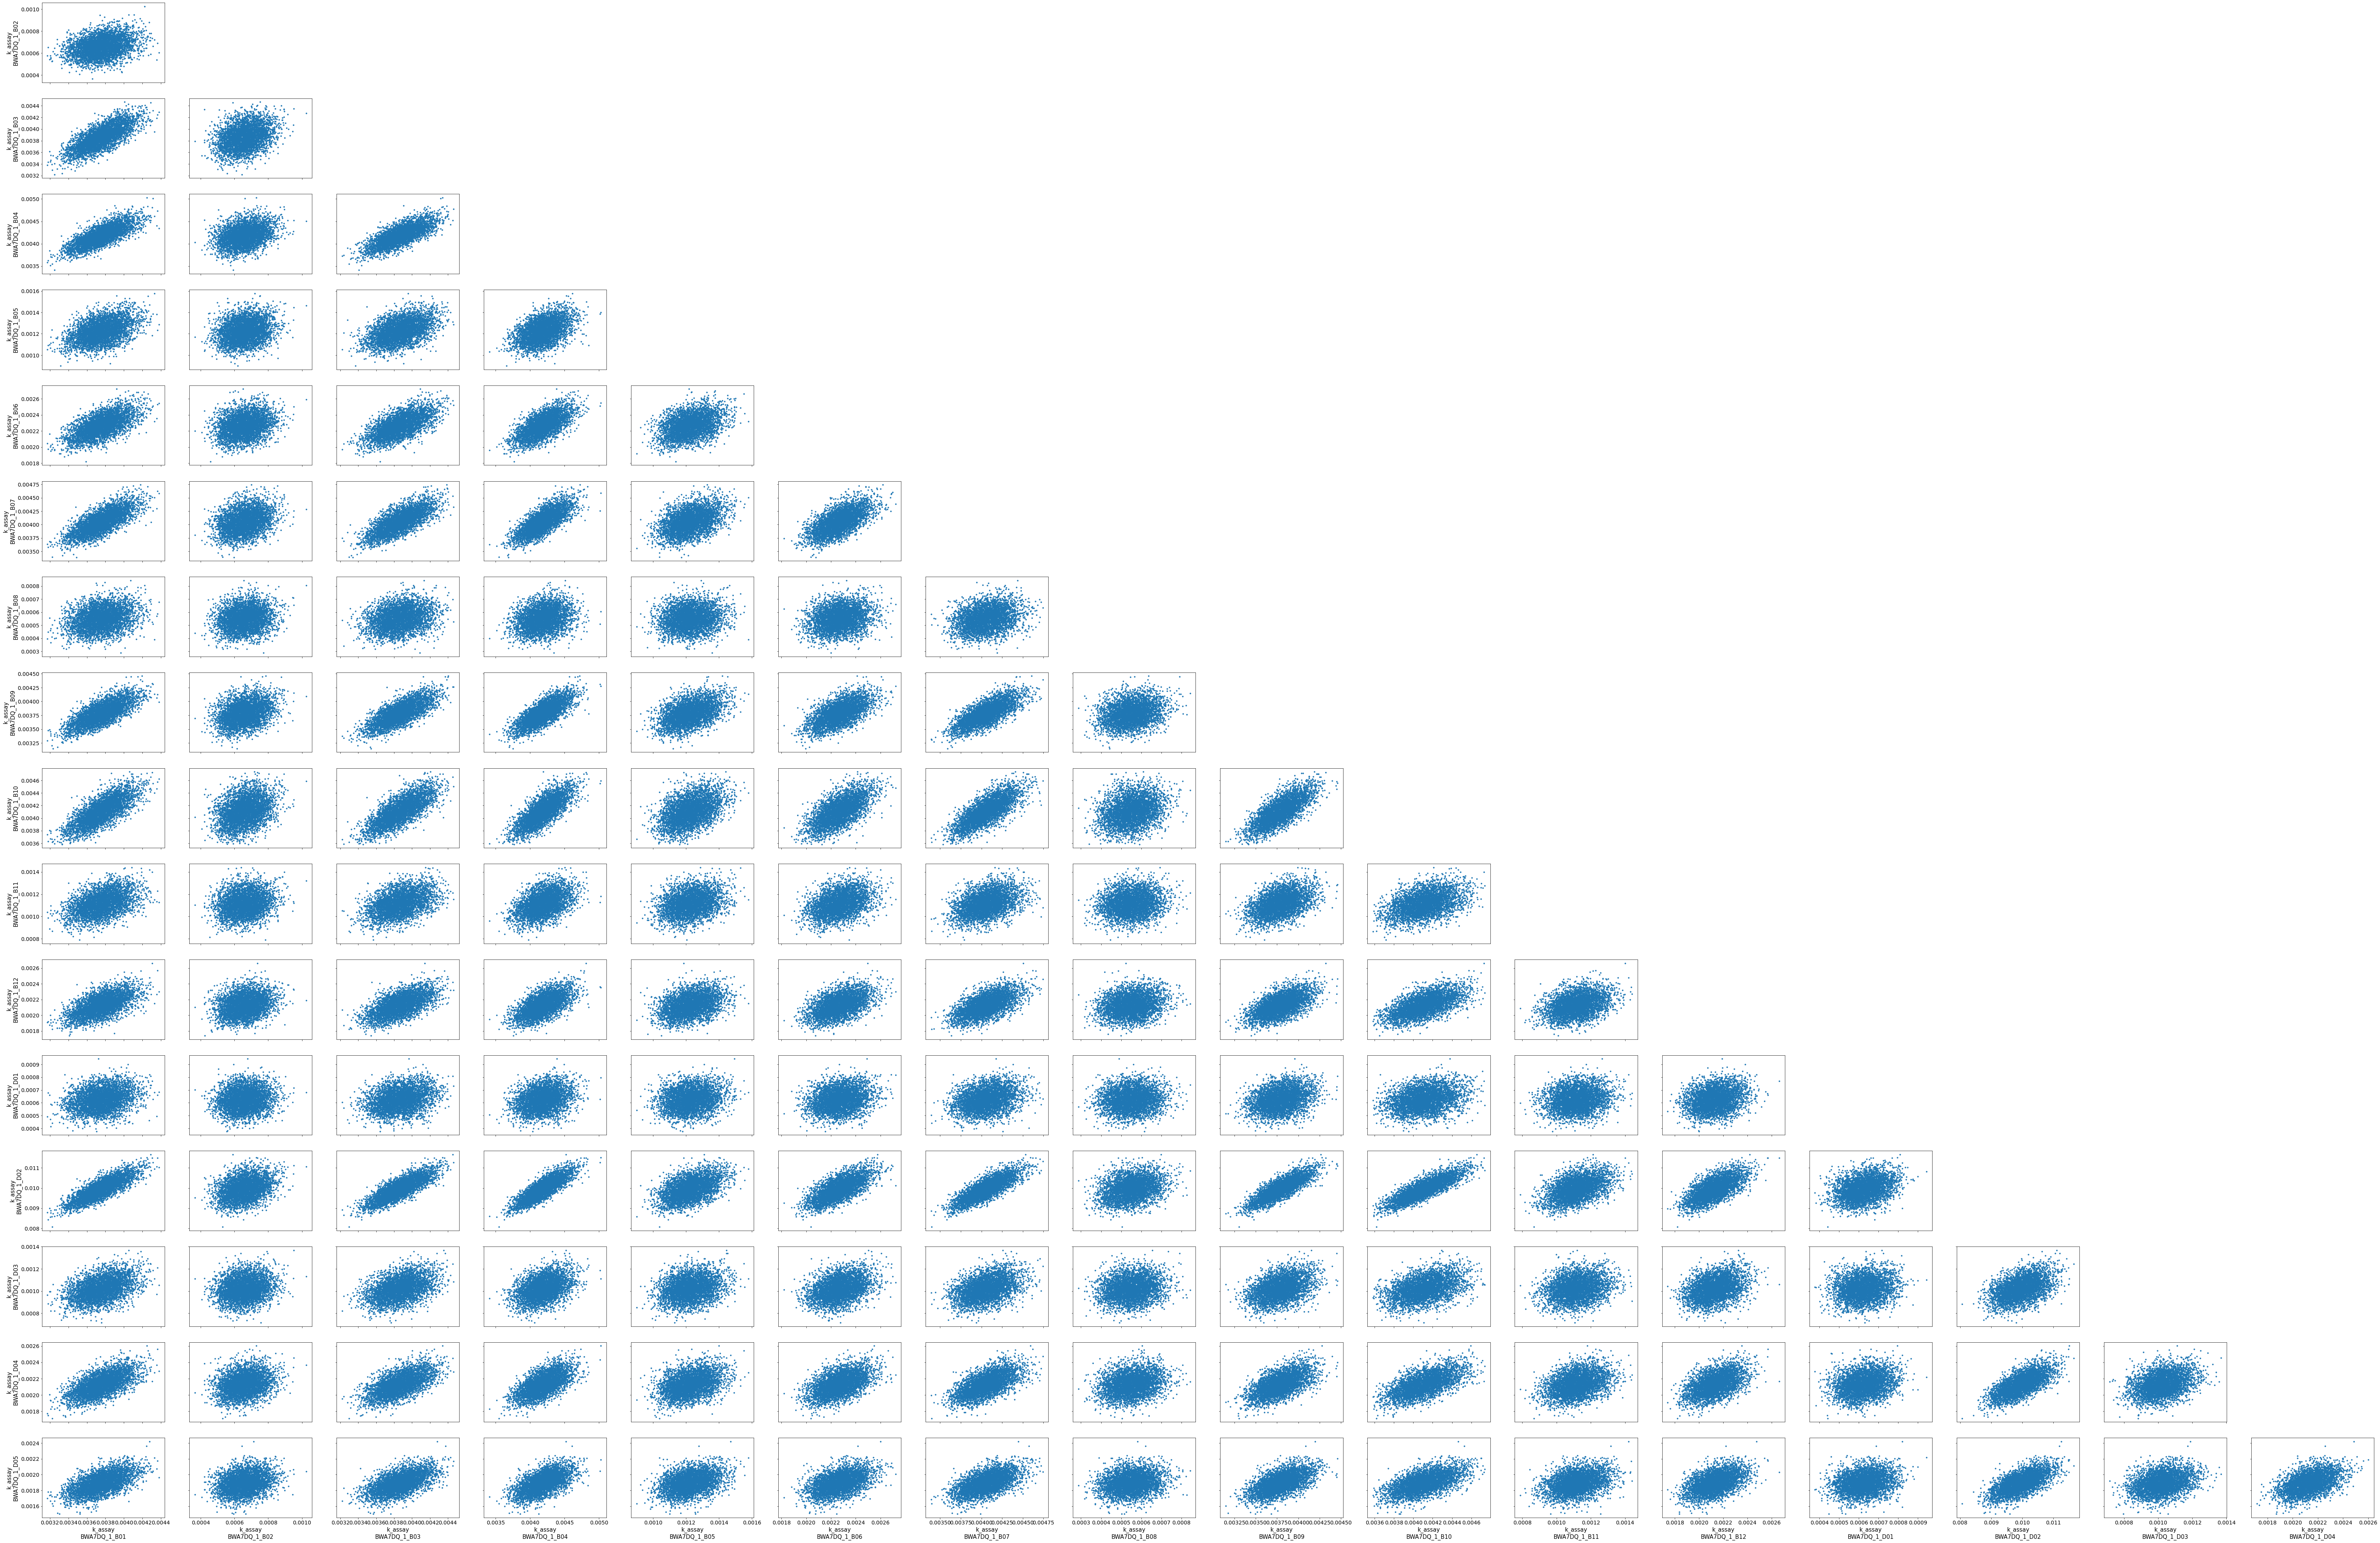

In [10]:
arviz.rcParams['plot.max_subplots'] = 144
arviz.plot_pair(idata, var_names=[
    "k_assay", 
    "k", "k_batch", "batch_effect", 
    "assay_effect"
]);

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

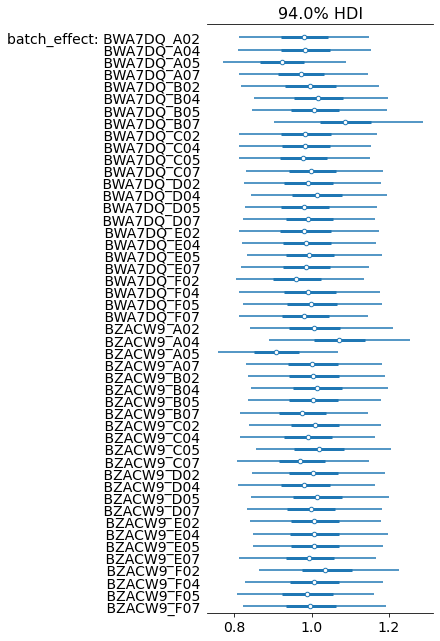

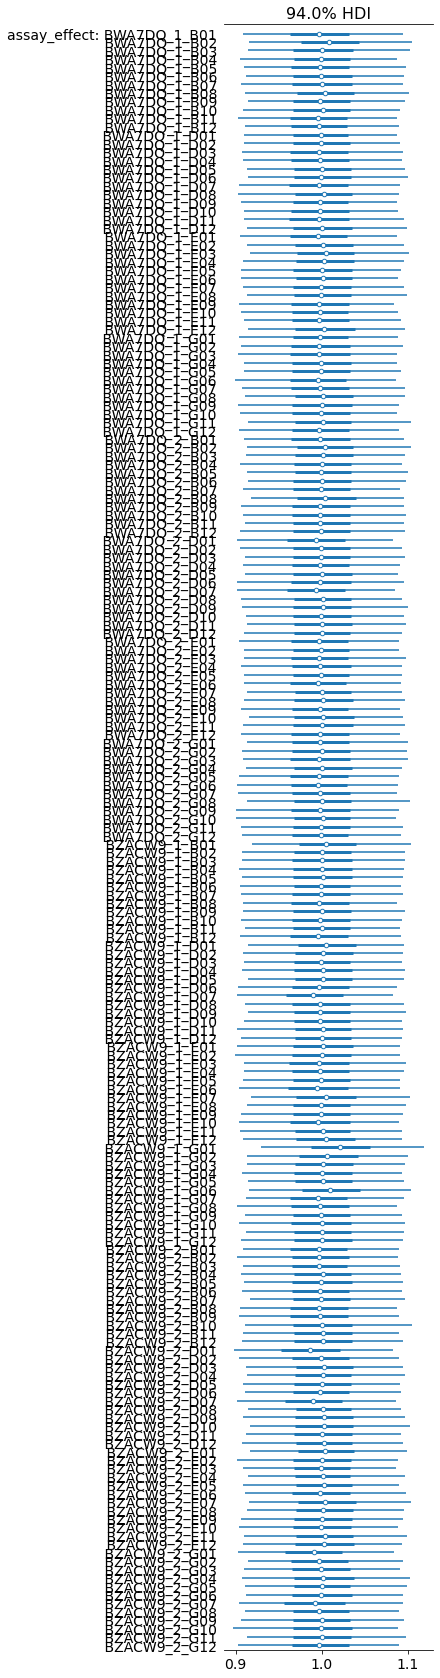

In [11]:
arviz.plot_forest(idata, var_names=["batch_effect"], combined=True)
arviz.plot_forest(idata, var_names=["assay_effect"], combined=True)

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

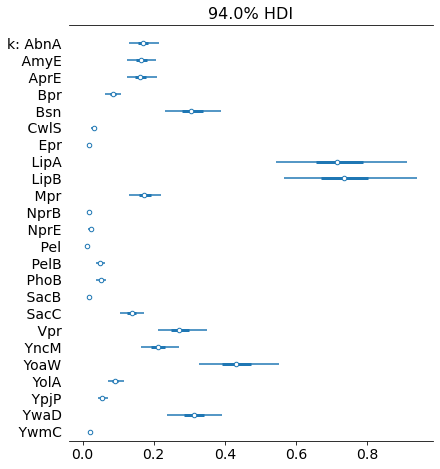

In [12]:
arviz.plot_forest(idata, var_names=["k"], combined=True)

In [15]:
posterior = idata.posterior.stack(sample=("chain", "draw"))
posterior

<xarray.Dataset>
Dimensions:                (kinetic_id: 192, sample: 4000, strain: 24, culture_id: 48, cutinase_cycle: 30)
Coordinates:
  * kinetic_id             (kinetic_id) <U12 'BWA7DQ_1_B01' ... 'BZACW9_2_G12'
  * strain                 (strain) <U4 'AbnA' 'AmyE' 'AprE' ... 'YwaD' 'YwmC'
  * culture_id             (culture_id) <U10 'BWA7DQ_A02' ... 'BZACW9_F07'
  * cutinase_cycle         (cutinase_cycle) int32 0 1 2 3 4 5 ... 25 26 27 28 29
  * sample                 (sample) MultiIndex
  - chain                  (sample) int64 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3
  - draw                   (sample) int64 0 1 2 3 4 5 ... 995 996 997 998 999
Data variables:
    cf_cutinase_assay      (kinetic_id, sample) float64 1.101 0.9652 ... 1.334
    k                      (strain, sample) float64 0.1342 0.1327 ... 0.02366
    batch_effect           (culture_id, sample) float64 0.907 1.006 ... 1.009
    assay_effect           (kinetic_id, sample) float64 0.9746 1.004 ... 0.9953
    S0                     (sample) float64 0.9598 0.9551 ... 0.9791 0.9988
    absorbance_intercept   (kinetic_id, sample) float64 0.4203 0.4483 ... 0.3627
    k_batch                (culture_id, sample) float64 0.1939 ... 0.01278
    k_assay                (kinetic_id, sample) float64 0.003823 ... 0.0003116
    product_concentration  (kinetic_id, cutinase_cycle, sample) float64 0.0 ....
Attributes:
    created_at:                 2021-09-15T15:51:42.064036
    arviz_version:              0.11.2
    inference_library:          pymc3
    inference_library_version:  4.0
    sampling_time:              655.9952464103699
    tuning_steps:               1000

In [16]:
pyrff.sample_batch(
    posterior.k.values,
    ids=numpy.unique(df_inputs.strain.values),
    batch_size=12,
    correlated=True
)

('LipB',
 'LipB',
 'LipB',
 'LipB',
 'LipB',
 'LipB',
 'LipA',
 'LipB',
 'LipA',
 'LipB',
 'LipA',
 'LipA')

red BZACW9_1_D04 BZACW9_D05
blue BZACW9_1_D10 BZACW9_D05
green BZACW9_2_D04 BZACW9_D05
orange BZACW9_2_D10 BZACW9_D05
red BWA7DQ_1_E01 BWA7DQ_A04
blue BWA7DQ_1_E07 BWA7DQ_A04
green BWA7DQ_2_E01 BWA7DQ_A04
orange BWA7DQ_2_E07 BWA7DQ_A04


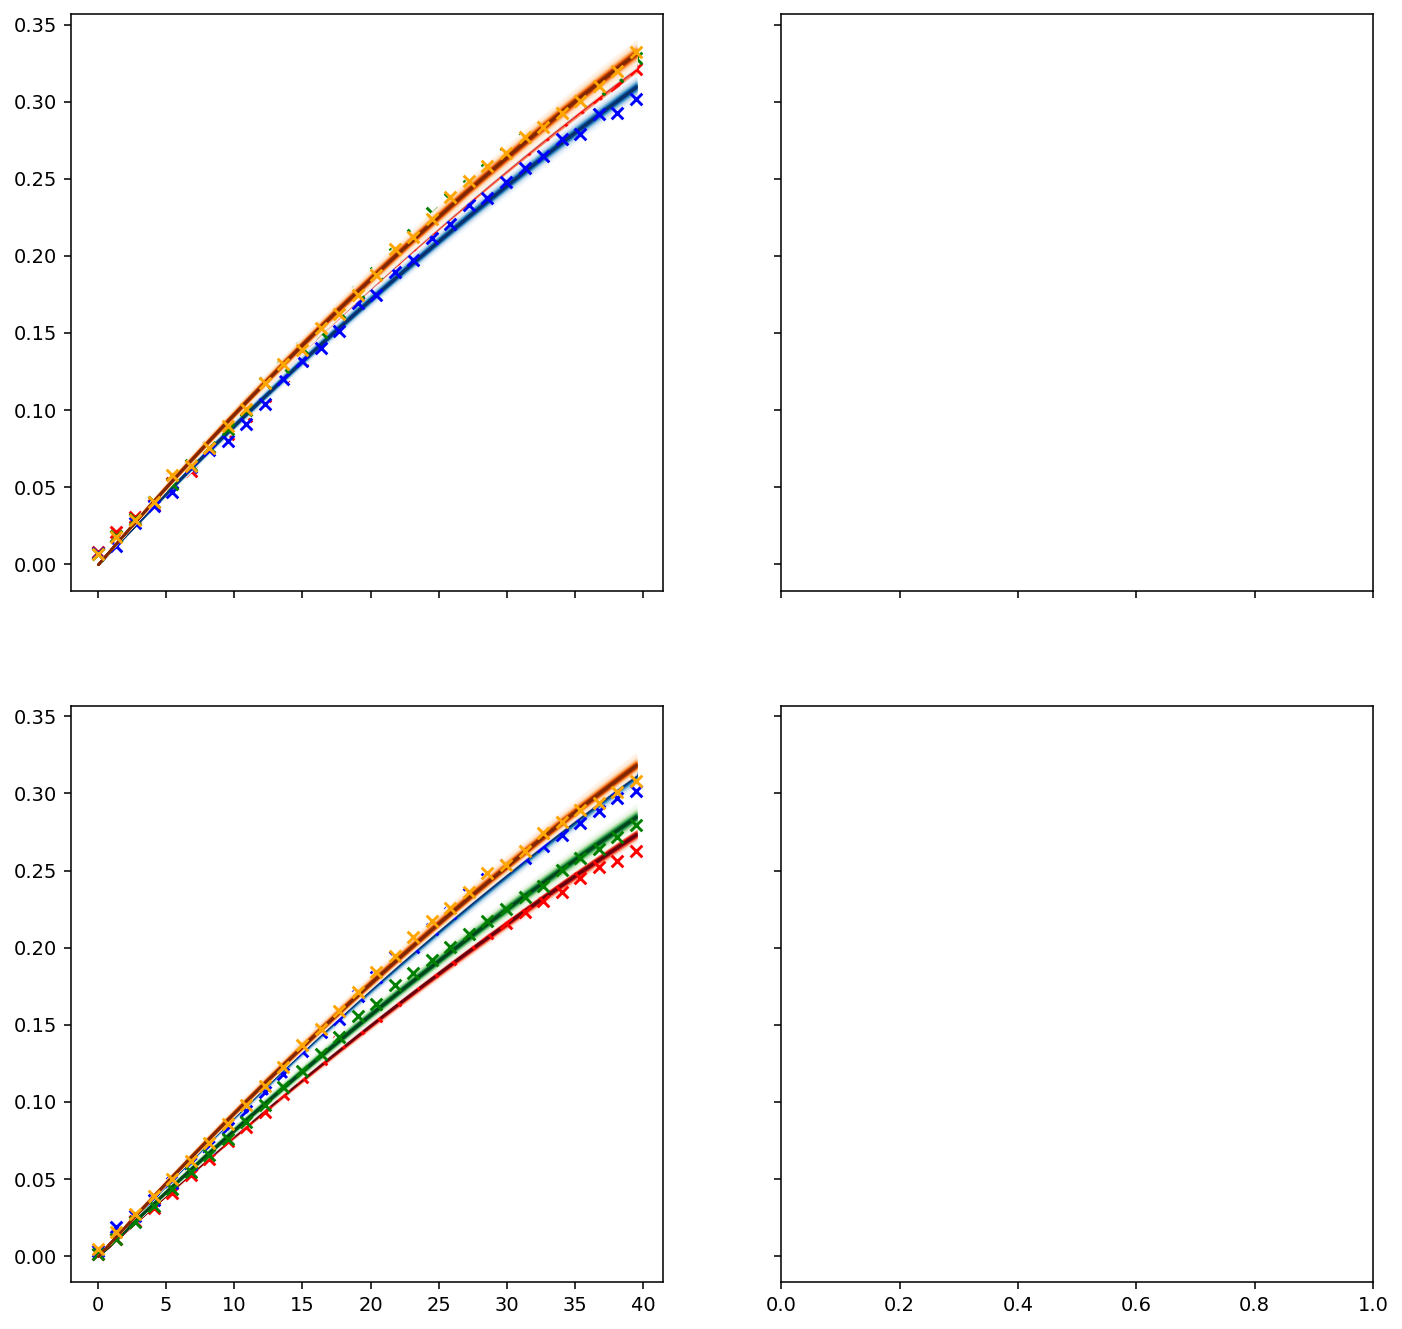

In [17]:
#for strain in posterior.strains.values:
strain="LipA"
culture_ids = df_inputs[df_inputs.strain==strain].index.to_list()
fig, axs = pyplot.subplots(
        dpi=140,
        figsize=(12, 6*len(culture_ids)),
        nrows=len(culture_ids),
        ncols=2,
        sharey=True,
        sharex="col",
        squeeze=False,
    )
for r, cid in enumerate(culture_ids):
    df = df_kinetics[df_kinetics.culture_id==cid]
    ax = axs[r,0]
    kinetic_ids = df.index
    residual_ptp = 0
    for c, (kid, (color, cmap)) in enumerate(zip(kinetic_ids, [
        ("red", "Reds"),
        ("blue", "Blues"),
        ("green", "Greens"),
        ("orange", "Oranges"),
    ])):


        # and the actual product concentration
        pymc3.gp.util.plot_gp_dist(
            ax=axs[r, 0],
            samples=posterior.product_concentration.sel(
                kinetic_id=kid
            ).values.T,
            x=idata.constant_data.cutinase_time[0,:].values,
            palette=cmap,
            plot_samples=False,
        )
        print(color, kid, cid)
        absorbance = idata.constant_data.cutinase_absorbance.sel(kinetic_id=kid)
        slope = cm_nitrophenol.theta_fitted[1]
        intercept = numpy.median(posterior.absorbance_intercept.sel(kinetic_id=kid).values)
        axs[r, 0].scatter(
            idata.constant_data.cutinase_time.values[0,:],
            (absorbance - intercept) / slope,
            marker="x",
            color=color,
        )

#         # formatting
#         axs[0, c].set_title(f"assay well {assay_well}")
#         axs[1, c].set_xlabel("time [h]")
#     axs[0, 0].set_ylim(0)
#     axs[0, 0].set_ylabel(
#         "Predicted product concentration"
#     )
#     axs[1, 0].set_ylim(-residual_ptp, residual_ptp)
#     axs[1, 0].set_ylabel("residual ")
#     fig.suptitle(
#         f"Model fit to '{sample_type}' replicates from input well {input_well}", y=1.01
#     )
#     fig.tight_layout()